# Model Training and Testing Script

## Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

## Datasets

In [72]:
# read in the dataset
df = pd.read_excel('./trad_dataset/DS-1 (P).xlsx')

df.drop(columns=['YearEnd'], inplace=True)

df.head()

,TeamExp,ManagerExp,Length,Effort,Transactions,Entities,PointsNonAdjust
0,1,4,12,5152,253,52,305
1,0,0,4,5635,197,124,321
2,4,4,1,805,40,60,100
3,0,0,5,3829,200,119,319
4,0,0,4,2149,140,94,234


In [4]:
print(len(df))

77


>There are 77 rows, 5 predictors, and 1 target in total

## Global Variables

In [73]:
TARGET = 'Effort'

#Choose all predictors except target & IDcols
PREDICTORS = [x for x in df.columns if x not in [TARGET]]

X = df[TARGET]
y = df[PREDICTORS]

## Model Fitting

In [74]:
def modelfit(alg, X_train, X_test, y_train, y_test, predictors, printFeatureImportance=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    Y_pred = alg.predict(X_test)
    diff = np.absolute(y_test-Y_pred)
    MRE = diff/y_test
    MMRE = np.mean(MRE)
    MAE = metrics.mean_absolute_error(y_test,Y_pred)
    
    #Print model report:
    print ("\nModel Report")
    print ("Average MMRE: %.4g" % MMRE)
    print ("Average MAE: %.4g" % MAE)

In [75]:
# split data for testing and training 
X_train, X_test, y_train, y_test = train_test_split(df[PREDICTORS], df[TARGET], test_size=0.3)

### Bagging

In [76]:
bag = BaggingRegressor(random_state=42)
modelfit(bag, X_train, X_test, y_train, y_test, PREDICTORS)


Model Report
Average MMRE: 1.06
Average MAE: 3074


### AdaBoost

In [77]:
ada = AdaBoostRegressor(random_state=42)
modelfit(ada, X_train, X_test, y_train, y_test, PREDICTORS)


Model Report
Average MMRE: 0.8509
Average MAE: 2634


### Random Forest Regressor

In [78]:
rf = RandomForestRegressor(random_state=42)
modelfit(rf, X_train, X_test, y_train, y_test, PREDICTORS)


Model Report
Average MMRE: 0.8239
Average MAE: 2455


### Gradient Boosting

In [79]:
gbm0 = GradientBoostingRegressor(random_state=42)
modelfit(gbm0, X_train, X_test, y_train, y_test, PREDICTORS)


Model Report
Average MMRE: 0.9017
Average MAE: 2691


## Hyperparameters Tuning
From the results above, we can see that the proposed models have similar MMRE but Random Forest Regressor outperforms the rest in terms of lower MAE. We will further tune 5 main tree-based hyperparameters of this model for optimization purposes, including n_estimators, min_samples_split, min_samples_leaf, max_depth, and max_features.

###  Fix number of estimators for tuning tree-based parameters

#### Test 1
Choose min_samples_split that should be at 0.5 to 1% of the total samples. Since we have 77 rows in total, so take 8 here. The max_depth should be chosen between 5 to 8 based on the observations and predictors. Since our dataset set is small, so take 5 here. The min_samples_leaf is used for preventing overfitting and again take a small value, 4, which is the half of the sample split in this case.

In [80]:
param_test1 = {'n_estimators':range(20,81,10)}
search1 = GridSearchCV(estimator = RandomForestRegressor(bootstrap=True, min_samples_split=8,min_samples_leaf=2,max_depth=5,max_features='sqrt',random_state=42), 
param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4,cv=5)
search1.fit(X_train,y_train)
search1.best_params_, search1.best_score_

({'n_estimators': 40}, -2139.0233914582896)

#### Test 2
Using the newly computed number of estimators, we will test min_samples_split from 8 to 40 in steps of 8. Also, we will test max_depth from 5 to 13 in steps of 2.

In [81]:
param_test2 = {'max_depth':range(5,14,2), 'min_samples_split':range(8,41,8)}
search2 = GridSearchCV(estimator = RandomForestRegressor(bootstrap=True,n_estimators=40,min_samples_leaf=2,max_features='sqrt',random_state=42), 
param_grid = param_test2, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
search2.fit(X_train,y_train)
search2.best_params_, search2.best_score_

({'max_depth': 5, 'min_samples_split': 8}, -2139.0233914582896)

#### Test 3
By using the parameter values computed from test 2, which produces a better result, we will test min_samples_leaf from 1 to 8 in steps of 1.

In [82]:
param_test3 = {'min_samples_leaf':range(1,9,1)}
search3 = GridSearchCV(estimator = RandomForestRegressor(bootstrap=True,n_estimators=40,max_depth=5,min_samples_split=8,max_features='sqrt',random_state=42), 
param_grid = param_test3, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
search3.fit(X_train,y_train)
search3.best_params_, search3.best_score_

({'min_samples_leaf': 3}, -2117.8210636126496)

#### Test 4
Choose min_samples_leaf as 3. We will test max_features from 1 to 6 in steps of 1 since we have only 6 predictors in our dataset.

In [83]:
param_test4 = {'max_features':range(1,6,1)}
search4 = GridSearchCV(estimator = RandomForestRegressor(bootstrap=True,n_estimators=40,max_depth=5,min_samples_leaf=3,min_samples_split=8,random_state=42),
param_grid = param_test4, scoring='neg_mean_absolute_error',n_jobs=4, cv=5)
search4.fit(X_train,y_train)
search4.best_params_, search4.best_score_

({'max_features': 2}, -2117.8210636126496)

#### Optimal tree-parameters:  

n_estimators: 40  
min_samples_split: 8  
min_samples_leaf: 3  
max_depth: 5  
max_features: 'sqrt'/2

### Results

In [84]:
rf_tuned = RandomForestRegressor(bootstrap=True,n_estimators=40,max_depth=5,min_samples_leaf=3,min_samples_split=8,max_features='sqrt',random_state=42)
modelfit(rf_tuned, X_train, X_test, y_train, y_test, PREDICTORS)


Model Report
Average MMRE: 0.7722
Average MAE: 2326


By tuning the hyperparameters, we can clearly see that the average MAE and MMRE decrease significantly. This model will be selected as our final model for traditional projects.

Text(0, 0.5, 'Feature Importance Score')

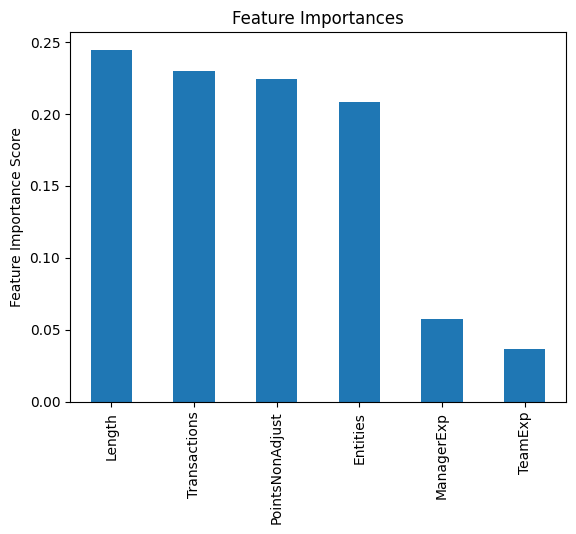

In [70]:
feat_imp = pd.Series(rf_tuned.feature_importances_, PREDICTORS).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Export Model

In [86]:
filename = "trad_trained_model.joblib"
joblib.dump(rf_tuned, filename)

['trad_trained_model.joblib']